# Data Exploration

In [3]:
from pivottablejs import pivot_ui
import pandas as pd
import numpy as np
titanic= pd.read_csv(r'C:\Users\annagp\Desktop\pyrepo\train.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
pivot_ui(titanic)

In [5]:

pivot_ui(titanic)

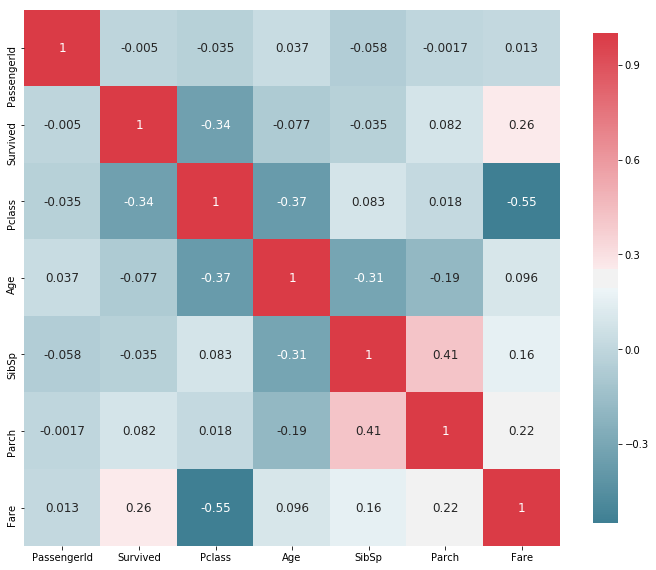

In [8]:
# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
def plot_correlation_map( df ):
    corr = titanic.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
plot_correlation_map( titanic )

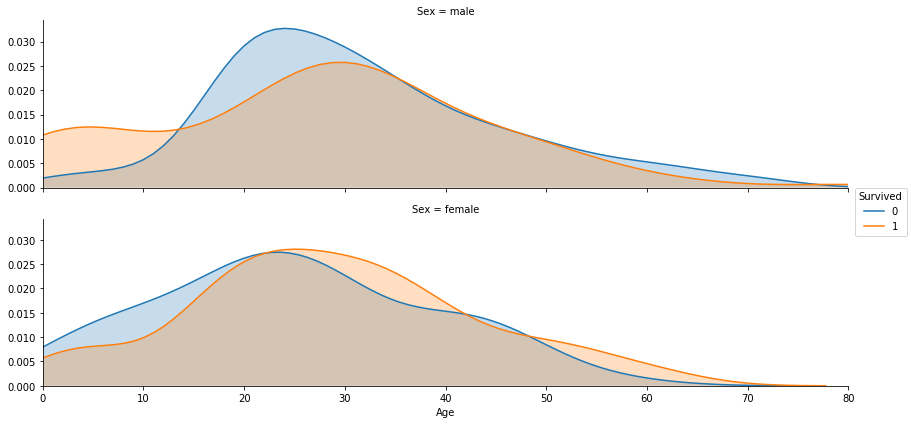

In [7]:
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    
plot_distribution( titanic , var = 'Age' , target = 'Survived' , row = 'Sex' )

#                                       Feature Enginnering

Steps:
1.Create family size and category for family size.
2.Fill missing values in variables.


In [9]:
family = pd.DataFrame()

# introducing a new feature : the size of families (including the passenger)
family[ 'FamilySize' ] = titanic[ 'Parch' ] + titanic[ 'SibSp' ] + 1

# introducing other features based on the family size
family[ 'Family_Single' ] = family[ 'FamilySize' ].map( lambda s : 1 if s == 1 else 0 )
family[ 'Family_Small' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 2 <= s <= 4 else 0 )
family[ 'Family_Large' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 5 <= s else 0 )

imputed = pd.DataFrame()

# Fill missing values of Age with the average of Age (mean)
imputed[ 'Age' ] = titanic.Age.fillna( titanic.Age.mean() )

# Fill missing values of Fare with the average of Fare (mean)
imputed[ 'Fare' ] = titanic.Fare.fillna( titanic.Fare.mean() )
titanic1 = titanic.drop(['Age'], axis=1)
full_X = pd.concat( [ imputed , family,titanic1] , axis=1 )

train_df = full_X.drop(['PassengerId', 'Name', 'Ticket', 'Cabin','FamilySize','SibSp','Parch'], axis=1)
train_df.head()
train_df.to_csv('train_df.csv', index=False, header=True)

# Create Logisctic Regression Model in SAS

In [10]:
import saspy
sas = saspy.SASsession(cfgname='winlocal')
%load_ext saspy.sas_magic

SAS Connection established. Subprocess id is 13688



In [11]:
%%SAS
proc import datafile="train_df.csv"
out=work.train_df;
run;
proc logistic data=train_df;
   class Embarked Sex;
   model Survived (event='1')= Age Fare Family_Single Family_Small Family_Large Pclass Sex Embarked /stepwise;
run;

Using SAS Config named: winlocal
SAS Connection established. Subprocess id is 16476




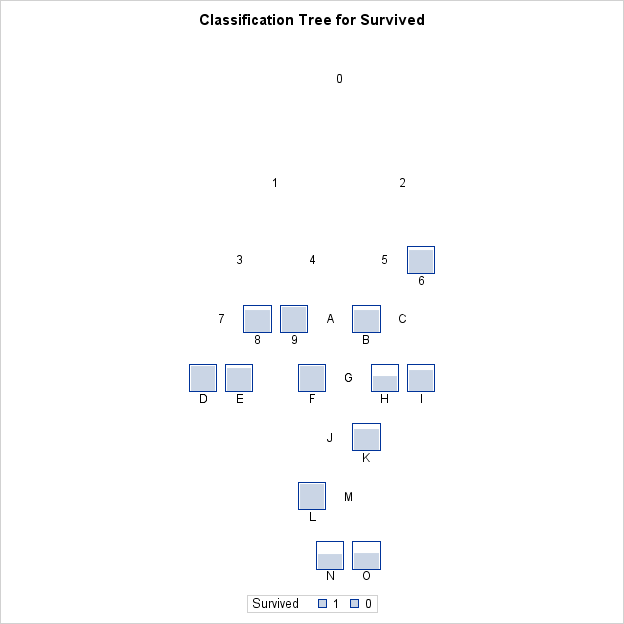
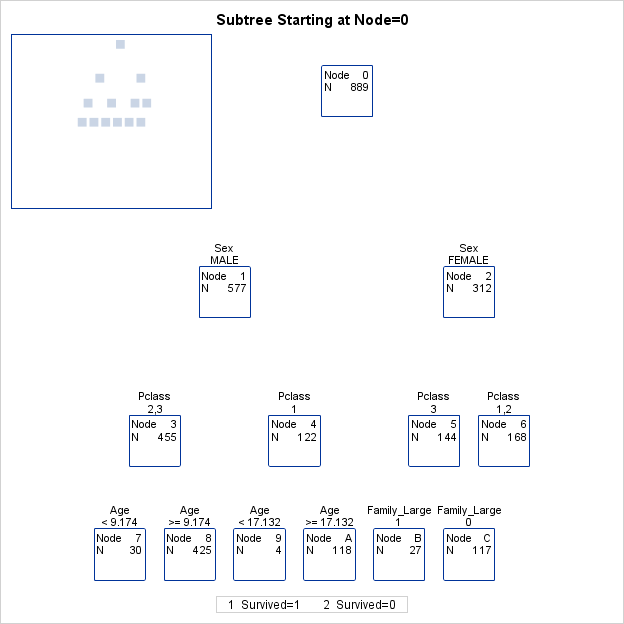
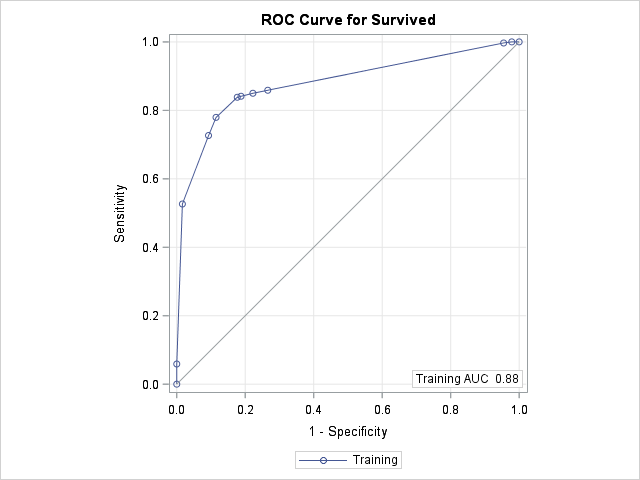
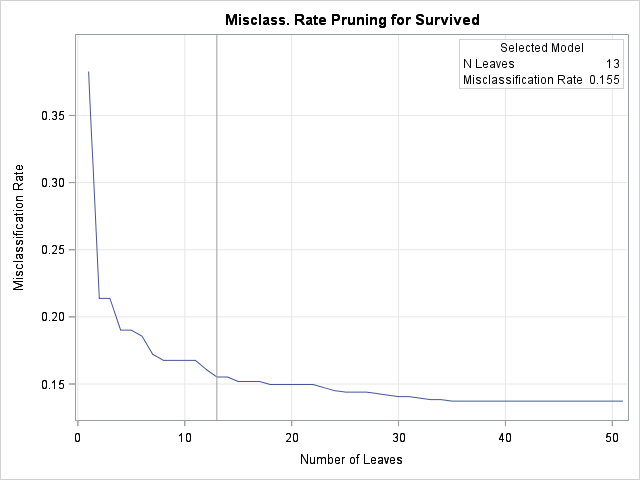

In [12]:
%%SAS
proc hpsplit data=train_df seed=123 maxdepth=7 maxbranch=2;
   target Survived;
   input  Family_Single Family_Small Family_Large Pclass Sex Embarked / level=nom;
   input Age Fare/level=int;
   criterion entropy;
   prune misc ;
run;